### Imports

In [26]:
import sqlalchemy
import duckdb  # to run SQL-like commands on pandas dataframes
import matplotlib.pyplot as plt
import pandas as pd
from datacockpit import DataCockpit

### Initialize Database engine

In [3]:
engine = sqlalchemy.create_engine('sqlite:////Users/<your_username>/mydb')

### Initialize DataCockpit

In [5]:
dcp_obj = DataCockpit(engine=engine, 
        path_to_logs="../data/query_logs.csv")

### Compute Usage Information

In [ ]:
dcp_obj.compute_usage()

### Get Usage Information

In [ ]:
metadata_df, aggr_df, dataset_usage_df = dcp_obj.get_usage()

In [7]:
metadata_df.head(3)

,index,database,dataset,attribute,query_type,query_id,timestamp,user,application,period_type,period
0,0,01org_virtual-storage-manager,metrics,metrics.metric,where,2,1668016389,user-3,cli,daily,2022-11-09
1,0,01org_virtual-storage-manager,metrics,metrics.metric,where,3,1668040568,user-6,web-prod,daily,2022-11-09
2,0,01org_virtual-storage-manager,migrate_version,migrate_version.*,select,5,1668078064,user-2,cli,daily,2022-11-10


In [8]:
aggr_df.head(3)

,database,dataset,attribute,query_type,period,count_queries
0,01org_virtual-storage-manager,metrics,metrics.metric,where,2022-11-09,2
1,01org_virtual-storage-manager,migrate_version,migrate_version.*,select,2022-11-10,1
2,01org_virtual-storage-manager,mysql.user,mysql.user.*,select,2022-11-10,1


In [9]:
dataset_usage_df.head(3)

,database,dataset,query_count,unique_user_count,dataset_usage_frequency_score,no_of_unique_users_score,overall_dataset_usage_score
0,01org_virtual-storage-manager,metrics,2,2,14,14,14
1,01org_virtual-storage-manager,migrate_version,1,1,7,7,7
2,01org_virtual-storage-manager,mysql.user,2,1,14,7,14


### Which are the most commonly queried datasets?

In [12]:
query = """
    SELECT dataset, Count(query_id) AS frequency 
    FROM metadata_df 
    GROUP BY dataset 
    ORDER BY frequency DESC
    LIMIT 5;
"""
print(duckdb.query(query).to_df())

         dataset  frequency
0         wnplts       5244
1           wijk        492
2        problem         78
3           user         63
4  brmo_metadata         50


### How many unique users queried each dataset?

In [14]:
query = """
    SELECT dataset, count(distinct user) AS user_count 
    FROM metadata_df GROUP BY dataset
    LIMIT 5;
"""
print(duckdb.query(query).to_df())

           dataset  user_count
0          metrics           1
1  migrate_version           1
2       mysql.user           1
3   storage_groups           1
4        proposals           1


### Which was the most frequent user per dataset?

In [17]:
query = """
    select distinct t1.dataset, (
        select user
        from metadata_df t2
        where t2.dataset = t1.dataset
        group by user
        order by count(*) desc
        limit 1
    ) as most_freq_user
    from metadata_df t1
    limit 5;
"""
print(duckdb.query(query).to_df())

# Caveat: This query "randomly" resolves ties

           dataset most_freq_user
0          metrics         duckdb
1  migrate_version         duckdb
2       mysql.user         duckdb
3   storage_groups         duckdb
4        proposals         duckdb


### Which was the most frequent column referenced per dataset?

In [18]:
query = """
    select distinct t1.dataset, (
        select attribute
        from metadata_df t2
        where t2.dataset = t1.dataset
        group by attribute
        order by count(*) desc
        limit 1
    ) as most_freq_attribute
    from metadata_df t1
    limit 5;
"""
print(duckdb.query(query).to_df())

# Caveat: This query "randomly" resolves ties

           dataset        most_freq_attribute
0          metrics             metrics.metric
1  migrate_version          migrate_version.*
2       mysql.user               mysql.user.*
3   storage_groups  storage_groups.choose_num
4        proposals           proposals.status


### Which was the most frequent column referenced per table?

In [20]:
query = """
    select distinct t1.dataset, (
        select attribute
        from metadata_df t2
        where t2.dataset = t1.dataset
        group by attribute
        order by count(*) desc
        limit 1
    ) as most_freq_attribute
    from metadata_df t1
    limit 5;
"""
print(duckdb.query(query).to_df())

# Caveat: This query "randomly" resolves ties

           dataset        most_freq_attribute
0          metrics             metrics.metric
1  migrate_version          migrate_version.*
2       mysql.user               mysql.user.*
3   storage_groups  storage_groups.choose_num
4        proposals           proposals.status


### Which application does each user most commonly use?

In [22]:
query = """
    select distinct t1.user, (
        select application
        from metadata_df t2
        where t2.user = t1.user
        group by application
        order by count(*) desc
        limit 1
    ) as most_freq_application
    from metadata_df t1
    limit 5;
"""
print(duckdb.query(query).to_df())

# Caveat: This query "randomly" resolves ties

     user most_freq_application
0  user-3              web-prod
1  user-6              web-prod
2  user-2              web-prod
3  user-1              web-prod
4  user-5              web-prod


### For each table, for each query type, which was the most commonly queried attribute?

In [23]:
query = """
    select distinct t1.dataset, t1.query_type, (
        select attribute
        from metadata_df t2
        where t2.dataset = t1.dataset and t2.query_type = t1.query_type
        group by attribute
        order by count(*) desc
        limit 1
    ) as most_freq_attribute
    from metadata_df t1
    limit 10;
"""
print(duckdb.query(query).to_df())

           dataset query_type        most_freq_attribute
0          metrics      where             metrics.metric
1  migrate_version     select          migrate_version.*
2       mysql.user     select   mysql.user.MAX_QUESTIONS
3   storage_groups     select  storage_groups.choose_num
4   storage_groups      where        storage_groups.name
5        proposals     update           proposals.status
6        proposals      where           proposals.status
7         versions     update         versions.item_type
8         versions      where         versions.item_type
9            users     select              users.user_id


### How did the most frequently accessed datasets grow with time?

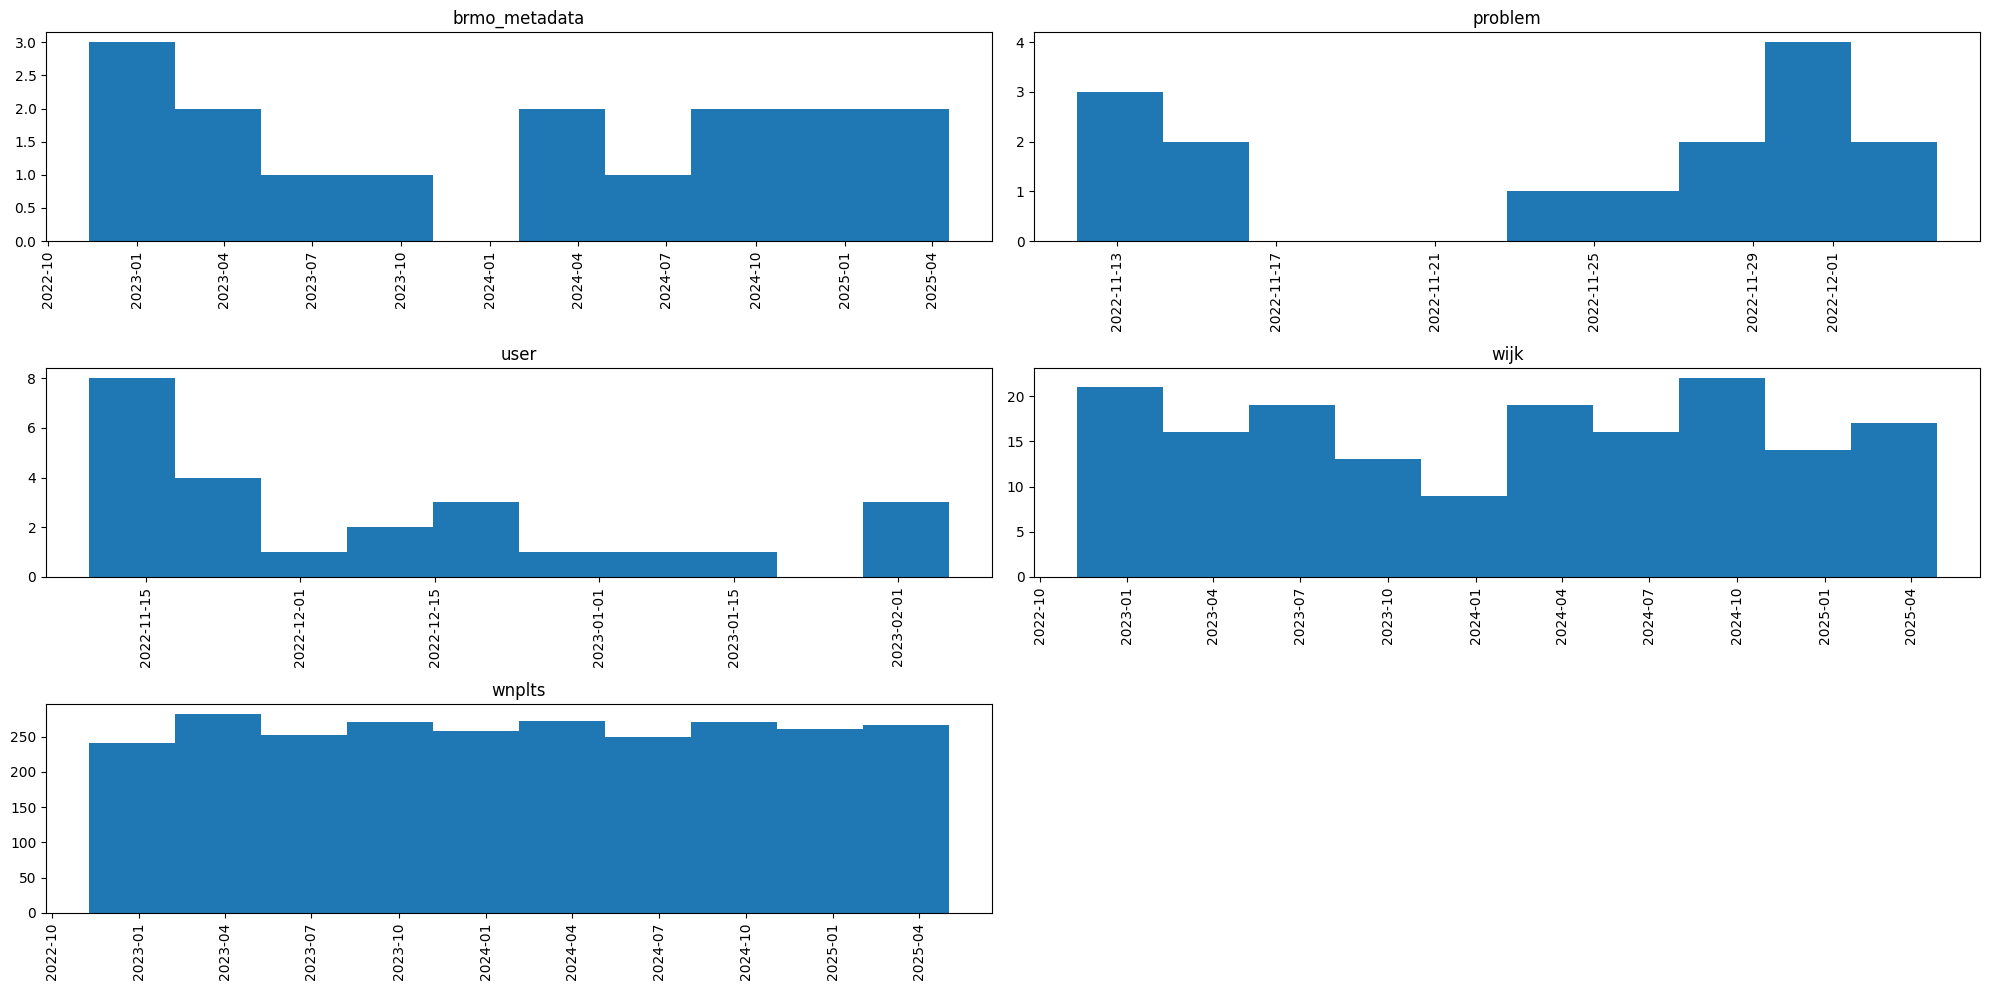

In [27]:

query = """
    SELECT DISTINCT dataset, query_id, timestamp
    FROM metadata_df WHERE dataset IN
     (SELECT dataset 
    FROM metadata_df 
    GROUP BY dataset 
    ORDER BY Count(query_id) DESC
    LIMIT 5)
    ;
"""

query_ts_table = duckdb.query(query).to_df()
query_ts_table['timestamp']= pd.to_datetime(query_ts_table['timestamp'], unit='s')
query_ts_table['timestamp'].hist(by=query_ts_table['dataset'], figsize=(20, 10))
plt.tight_layout()
plt.show()



### For the biggest datasets, what is the breakdown of the application?

  dataset  query_id application
0   users        11    web-prod
1   users        27    web-prod
2   users        41    web-prod
3   users        45    web-prod
4   users        49    web-prod


Text(0, 0.5, 'Count of queries')

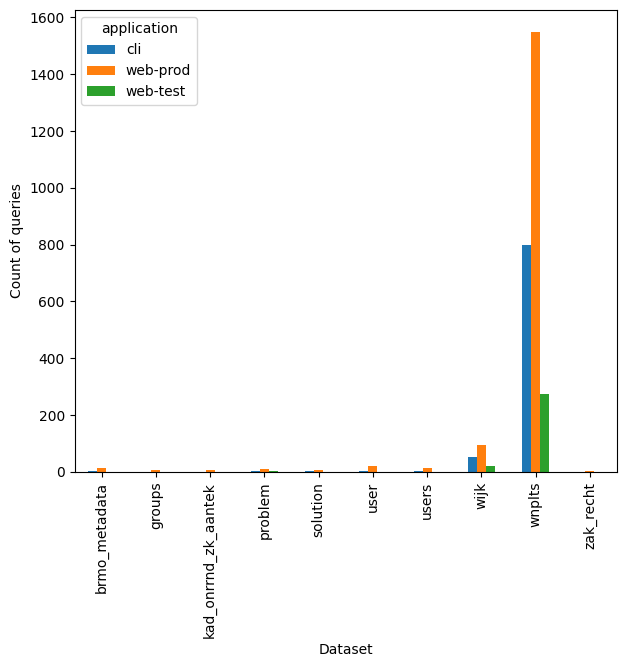

In [30]:
query = """
    SELECT DISTINCT dataset, query_id, application
    FROM metadata_df WHERE dataset IN
     (SELECT dataset 
    FROM metadata_df 
    GROUP BY dataset 
    ORDER BY Count(query_id) DESC
    LIMIT 10)
    ;
"""
query_ts_table = duckdb.query(query).to_df()
print(query_ts_table.head())
df_pivot = pd.pivot_table(
	query_ts_table,
	values="query_id",
	index="dataset",
	columns="application",
	aggfunc="count"
)

# Plot a bar chart using the DF
ax = df_pivot.plot(kind="bar")
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xlabel("Dataset")
ax.set_ylabel("Count of queries")



### Which are the datasets that have a higher number of cli commands as opposed to web-prod? 

In [32]:
# This acts as outlier detection since our probabilities of prod, cli, and test are .6, 0.3, and .1
query = """
    SELECT dataset, 
    COUNT(DISTINCT query_id) FILTER(WHERE application = 'cli') AS cli_count,
    COUNT(DISTINCT query_id) FILTER(WHERE application = 'web-prod') AS web_prod_count,
    COUNT(DISTINCT query_id) FILTER(WHERE application = 'web-test') AS web_test_count,
    cli_count - web_prod_count AS diff_cli_web_prod
    FROM metadata_df GROUP BY dataset
    ORDER BY diff_cli_web_prod DESC;
"""
query_ts_table = duckdb.query(query).to_df()
print(query_ts_table.head())

                dataset  cli_count  web_prod_count  web_test_count  \
0              gemeente          3               0               0   
1  pv_verblijfsobj_pand          3               0               0   
2               profile          3               0               1   
3               message          3               1               0   
4          brondocument          2               0               2   

   diff_cli_web_prod  
0                  3  
1                  3  
2                  3  
3                  2  
4                  2  
